In [1]:
import math
from numpy import linalg as LA
import sympy as sp
import numpy as np
import random
from numba import njit, prange, cuda

def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError


def fFeim(x, pole, resi, sigma=1):
    return 1 / 2 - sigma * sum(2.0 * resi[i] * x / (x**2 + pole[i]**2)
                               for i in range(len(pole)))


def tseig(D, E):
    mat = np.diag(E, -1) + np.diag(D, 0) + np.diag(E, 1)
    return -np.sort(-np.linalg.eigvalsh(mat))


def MSD(N, BoseFermi=2):
    if BoseFermi == 1:
        pole = np.array([2 * (i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi
    elif BoseFermi == 2:
        pole = np.array([(2 * i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi


def PSD(N, BoseFermi=2, pade=0):
    if N < 0 or BoseFermi < 1 or BoseFermi > 2 or pade < 0 or pade > 3:
        raise ValueError("N or BoseFermi or pade has wrong value!")

    if pade == 0:
        return MSD(N, BoseFermi)
    elif pade == 1 or pade == 2:
        pole, resi = [], []
        if N > 0:
            M = 2 * N + pade // 2
            temp = 3.0 if BoseFermi == 1 else 1.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            pole = 2.0 / tseig(diag, doff)[:N]
            pol2 = np.array([x * x for x in pole])
            M -= 1
            temp = 5.0 if BoseFermi == 1 else 3.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            M //= 2
            eig2 = np.power(2.0 / tseig(diag, doff)[:M], 2)
            print(eig2)

            scaling = 0.0
            if BoseFermi == 1:
                scaling = N*(2.0*N+3.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+3.0))
            elif BoseFermi == 2:
                scaling = N*(2.0*N+1.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+1.0))
            resi = np.zeros(N, dtype=float)
            for j in range(N):
                if pade == 2:
                    temp = 0.5 * scaling * (eig2[j] - pol2[j])
                elif pade == 1:
                    if j == N - 1:
                        temp = 0.5 * scaling
                    else:
                        temp = 0.5*scaling * \
                            (eig2[j]-pol2[j])/(pol2[N-1]-pol2[j])
                for k in range(M):
                    temp *= (eig2[k]-pol2[j]) / \
                        (pol2[k]-pol2[j]) if k != j else 1.0
                resi[j] = temp
        rn, tn = 0.0, 0.0
        if BoseFermi == 1 and pade == 2:
            rn = 1.0 / (4.0 * (N + 1.0) * (2.0 * N + 3.0))
        return pole, resi
    elif pade == 3:
        Np1 = N + 1
        temp = 3.0 if BoseFermi == 1 else 1.0
        d = np.empty(2 * Np1, dtype=float)
        d[0] = 0.25 / temp
        d[-1] = -4.0 * (N + 1.0) * (N + 1.0) * (temp + 2 * N) * (
            temp + 2 * N) * (temp + 4 * N + 2.0)
        for i in range(1, Np1):
            d[2*i-1] = -4.0*i*i*(temp+2.0*i-2.0) * \
                (temp+2.0*i-2.0)*(temp+4.0*i-2.0)
            d[2 * i] = -0.25 * (temp + 4.0 * i) / i / (i + 1) / (
                temp + 2.0 * i - 2.0) / (temp + 2.0 * i)
        sumd2 = np.empty(Np1, dtype=float)
        sumd2[0] = d[1]
        for i in range(1, Np1):
            sumd2[i] = sumd2[i - 1] + d[2 * i + 1]
        tn = 0.25 / sumd2[-1]
        rn = sum(d[2 * i] * (4.0 * tn *
                             (sumd2[-1] - sumd2[i - 1]))**2 if i > 0 else d[2 *
                                                                            i]
                 for i in range(Np1))
        M = 2 * N + 1
        diag = np.zeros(M, dtype=float)
        doff = np.array(
            [1.0 / math.sqrt(d[i + 1] * d[i + 2]) for i in range(M - 1)])
        pole = 2.0 / tseig(diag, doff)[:N]
        resi = np.zeros(N, dtype=float)
        for j in range(N):
            scaling = pole[j] * pole[j]
            r0, t1 = 0.0, 0.25 / d[1]
            eta0, eta1, eta2 = 0.0, 0.5, 0.0
            for i in range(Np1):
                r1 = t1 if (i == j
                            or i == N) else t1 / (pole[i] * pole[i] - scaling)
                r2 = 2.0*math.sqrt(abs(r1)) if r1 > 0 else - \
                    2.0*math.sqrt(abs(r1))
                r1 = 2.0 * math.sqrt(abs(r1))
                eta2 = d[2 * i] * r1 * eta1 - 0.25 * r1 * r0 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                eta2 = d[2 * i +
                         1] * r2 * eta1 - 0.25 * r2 * r1 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                r0 = r2
                if i != N:
                    t1 = sumd2[i] / sumd2[i + 1]
            resi[j] = eta2
        return pole, resi


def arma_print(ndarray):

    shape = ndarray.shape
    dimen = len(shape)

    if dimen == 1:

        if issubclass(type(ndarray[0]), np.int_):
            print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('%d' % row)
        elif issubclass(type(ndarray[0]), float):
            print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('%.8e' % row)
        elif issubclass(type(ndarray[0]), complex):
            print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('(%.8e,%-.8e)' % (row.real, row.imag))

    elif dimen == 2:

        if issubclass(type(ndarray[0, 0]), np.int_):
            print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('%d' % x for x in row))
        elif issubclass(type(ndarray[0, 0]), float):
            print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('%.8e' % x for x in row))
        elif issubclass(type(ndarray[0, 0]), complex):
            print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag) for x in row))

    elif dimen == 3:

        if issubclass(type(ndarray[0, 0, 0]), np.int_):
            print('ARMA_CUB_TXT_IS004\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('%d' % x for x in row))
        elif issubclass(type(ndarray[0, 0, 0]), float):
            print('ARMA_CUB_TXT_FN008\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('%-.8e' % x for x in row))
        elif issubclass(type(ndarray[0, 0, 0]), complex):
            print('ARMA_CUB_TXT_FC016\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                   for x in row))


def arma_write(ndarray, filename):

    shape = ndarray.shape
    dimen = len(shape)

    with open(filename, 'w') as f:
        if dimen == 1:
            if issubclass(type(ndarray[0]), np.int_):
                print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('%d' % row, file=f)
            elif issubclass(type(ndarray[0]), float):
                print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('%.8e' % row, file=f)
            elif issubclass(type(ndarray[0]), complex):
                print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('(%.8e,%-.8e)' % (row.real, row.imag), file=f)

        elif dimen == 2:

            if issubclass(type(ndarray[0, 0]), np.int_):
                print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('%d' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0]), float):
                print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('%.8e' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0]), complex):
                print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                   for x in row),
                          file=f)

        elif dimen == 3:

            if issubclass(type(ndarray[0, 0, 0]), np.int_):
                print('ARMA_CUB_TXT_IS004\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('%d' % x for x in row))
            elif issubclass(type(ndarray[0, 0, 0]), float):
                print('ARMA_CUB_TXT_FN008\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('%-.8e' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0, 0]), complex):
                print('ARMA_CUB_TXT_FC016\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                       for x in row),
                              file=f)


# in this script, we can decompose any given spectrum, but the sympy format is must been given
# do u like haskell?
# sympy[spe(def by sympy)], dict[sp_para_dict], dict[para_dict], dict[npsd],
# dict[pade] >> np.array[etal], np.array[etar],np.array[etaa], np.array[expn]


def decompose_spe(spe,
                  sp_para_dict,
                  para_dict,
                  condition_dict,
                  npsd,
                  sigma,
                  pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []

    expn = np.array(expn)

    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]

    expn_val_cc = []
    # expn_arg_cc = expn_imag_sort[expn_imag != 0]
    expn_val_n_cc = expn
    # expn_arg_n_cc = expn_imag_sort[expn_imag == 0]

    expn = list(expn[expn_imag_sort])
    pole, resi = PSD(npsd, 2, 1)
    beta = para_dict['beta']
    temp = 1 / beta

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 2.j * numer_get_para / np.multiply.reduce(
                    w_sp - poles_allplane[np.abs(poles_allplane - sigma * 1.J *
                                                 expn_val_n_cc[ii]) > 1e-14])
                      ).subs({w_sp: sigma * 1.j * expn_val_n_cc[ii]}) *
                     fFeim(sigma * 1.J * expn_val_n_cc[ii] / temp, pole, resi,
                           sigma))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    f = numer_get_para / np.multiply.reduce(w_sp - poles_allplane)
    f = sp.lambdify(w_sp, f)

    for inma in range(len(pole)):
        print(pole[inma])
        zomg = sigma * 1.J * pole[inma] * temp
        jsum = np.sum(f(zomg))
        expn.append(pole[inma] * temp)
        etal.append(-2.J * resi[inma] * temp * jsum)
        etar.append(np.conj(etal[-1]))
        etaa.append(np.abs(etal[-1]))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


def decompose_spe_real(spe,
                       sp_para_dict,
                       para_dict,
                       condition_dict,
                       sigma,
                       pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []
    expn = np.array(expn)
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 1.j * numer_get_para /
                      np.multiply.reduce(w_sp - poles_allplane[np.abs(
                          poles_allplane -
                          sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])).subs(
                              {w_sp: sigma * 1.j * expn_val_n_cc[ii]}))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


@njit()
def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w)


def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res


def fit_t_d1(t, res, expn, etal):
    for i in range(len(etal)):
        res += -expn[i] * etal[i] * np.exp(-expn[i] * t)
    return res


def INDEX3(i, j, k, mum):
    return mum * mum * i + mum * j + k


def fit_prony(phixx, n, error):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = len(vs[vs > error]) + 1
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        print(i)
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new


def fit_prony_n(phixx, n, n_choose):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = n_choose
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new

In [2]:
PSD(2, BoseFermi=2, pade=2)

[ 39.76486849 380.23513151]


(array([ 3.14161577, 10.10595124]), array([1.00007741, 1.56658926]))

In [3]:
# """
# beylkin.py
# Usage:  python beylkin.py
# Note:  This code fits growing and decaying functions that may be well approximated
# in a basis of complex exponential functions.  Data sets may be fitted using the
# driver_load method.  Equally spaced data points are required.  
# Reference:  G. Beylkin and L. Monzon, Appl. Comput. Harmon. Anal. 19, 17 (2005).
# Author: Ian S. Dunn, Columbia University Department of Chemistry, isd2107@columbia.edu
# """

# # Import modules.
# import sys
# import numpy as np
# from scipy.sparse.linalg import eigsh
# import matplotlib.pyplot as plt
# import scipy


# class Beylkin:
#     def __init__(self, decaying=False):

#         self.x = None
#         self.h = None
#         self.N = None
#         self.H = None
#         self.ceigenvec = None
#         self.gamma = None

#         self.decaying = decaying

#     def load_data(self, x, h):
#         assert len(x) == len(h)
#         self.N = (len(x) - 1) // 2
#         self.x = np.array(x[:2 * self.N + 1], dtype=float)
#         self.h = h[:2 * self.N + 1]
#         self.dx = float(self.x[1] - self.x[0])
#         self.T = self.x[-1] - self.x[0]

#     def sample(self, f, start=0, end=1, N=214):
#         # Number of points for sampling.
#         self.N = N
#         # Sampling grid.
#         self.x = np.linspace(0,
#                              1,
#                              2 * N + 1,
#                              endpoint=True,
#                              dtype=np.complex128)

#         # Evaluate function on grid.
#         self.h = f(self.x)

#     def plot_input(self):

#         # Plot function.
#         plt.plot(self.x, self.h)
#         plt.show()

#     def build_hankel(self):

#         assert self.h is not None

#         # Build Hankel matrix.
#         self.H = scipy.linalg.hankel(self.h[:2 * self.N + 1].astype(
#             np.complex128))[:self.N + 1, :self.N + 1]

#         # Check that Hankel matrix is real and symmetric.
#         assert np.allclose(self.H, self.H.T, atol=1.e-15)

#     def eigen(self, nsing):

#         assert self.H is not None

#         # Initial Krylov vector.
#         v0 = np.zeros(len(self.H), dtype=np.complex128)
#         v0[0] = 1.

#         # Calculate singular vectors and values of Hankel matrix.
#         w, v = eigsh(self.H, k=nsing + 1, v0=v0)

#         # Find smallest numerically acceptable c-eigenpair.
#         w_max = np.max(abs(w))
#         threshold = w_max * 1.e-15
#         large = np.where(abs(w) > threshold)[0]
#         v = v[:, large]
#         w = w[large]

#         ind = np.argmin(abs(w))
#         self.ceigenvec = v[:, ind]

#         #print "Approximate Prony analysis with", small_ind, "th singular value."

#     def nodes(self):

#         assert self.ceigenvec is not None

#         # Evaluate roots of c-eigenpolynomial.
#         gamma = np.roots(self.ceigenvec[::-1])

#         # Remove large roots.
#         max_gamma = (np.max(abs(self.h)) * 1000.)**(1. / (2 * self.N))
#         large_inds = np.where(abs(gamma) > max_gamma)
#         gamma = np.delete(gamma, large_inds)

#         # Remove small roots.
#         if self.decaying:
#             gamma = np.delete(gamma, np.where(abs(gamma) > 1.))
#         else:
#             gamma = np.delete(gamma, np.where(abs(gamma) < 1.))

#         # Store nodes.
#         self.gamma = gamma

#     def calculate_weights(self, nsing):

#         assert self.gamma is not None
#         assert self.gamma.size > 0

#         # Build Vandermonde matrix from c-eigenroots.
#         self.vand = np.vander(self.gamma, N=2 * self.N + 1).transpose()[::-1]

#         # Normalize Vandermonde columns to improve conditioning of least squares by SVD.
#         self.vand_norm = np.linalg.norm(self.vand, axis=0)
#         self.vand /= self.vand_norm
#         self.vand[np.where(abs(self.vand) < 1.e-14)] = 0

#         # Change basis from complex exponentials to oscillating real exponentials.
#         lamda_dt = np.log(self.gamma)
#         omega_real_dt = np.real(lamda_dt)
#         omega_imag_dt = np.imag(lamda_dt)
#         self.vand = abs(self.vand)

#         # Indices where weights correspond to damped cosines, damped sines, and monotonically damped functions.
#         self.cos_inds = np.where(omega_imag_dt > 1.e-10)[0]
#         self.sin_inds = np.where(omega_imag_dt < -1.e-10)[0]
#         self.monotonic_inds = np.where(abs(omega_imag_dt) <= 1.e-10)[0]

#         for i, wt in enumerate(omega_imag_dt):

#             if wt > 1.e-10:
#                 self.vand[:, i] *= np.cos(omega_imag_dt[i] *
#                                           np.arange(self.vand.shape[0]))
#             elif wt < -1.e-10:
#                 self.vand[:, i] *= -np.sin(
#                     omega_imag_dt[i] * np.arange(self.vand.shape[0]))

#         # Calculate Prony weights using least squares fit.
#         lstsq_ret = scipy.linalg.lstsq(self.vand, self.h, cond=1.e-13)
#         self.weights = lstsq_ret[0]

#         # Remove small weights.
#         self.weights[np.where(abs(self.gamma) < 1.e-14)] = 0.

#         # Sort weights.
#         inds = np.argsort(abs(self.weights))

#         # Set small weights to zero.
#         self.weights[inds[:-nsing]] = 0

#     def plot_components(self):

#         # Plot absolute value of Prony components.
#         for i in range(self.vand.shape[1]):
#             plt.plot((self.vand[:, i]))
#         plt.show()

#     def prony(self):

#         assert self.vand is not None
#         assert self.weights is not None

#         # Construct approximate Prony approximation.
#         self.approx = np.dot(self.vand, self.weights)

#     def plot_prony(self):
#         assert self.approx is not None
#         # Plot original function and approximate Prony approximation.
#         plt.plot(self.approx)
#         plt.plot(self.h)
#         plt.show()
        
#     def plot_prony_error(self):
#         assert self.approx is not None
#         # Plot original function and approximate Prony approximation.
#         plt.plot(self.approx-self.h)
#         plt.show()

#     def correction(self):

#         inds = np.where(abs(self.gamma) <= 1.)
#         weights = np.copy(self.weights)
#         #weights[inds] = 0.

#         return np.dot(self.vand, weights)

#     def prony_function(self, x):
#         """Function for calculating approximate Prony decomposition on arbitrary grid."""

#         # Convert domain to float.
#         x = np.array(x - self.x[0], dtype=float)

#         # Rescale domain to units where sampled data has a spacing of 1.
#         x /= self.dx

#         # Array for storing output.
#         result = np.zeros_like(x)

#         # Decay constants and oscillation frequencies.
#         lamda_dt = np.log(self.gamma)
#         lamda_dt_real = np.real(lamda_dt)
#         lamda_dt_imag = abs(np.imag(lamda_dt))

#         # Account for rescaling in least squares fit.
#         weights = self.weights / self.vand_norm
#         weights[np.where(lamda_dt_real < 2.e-2 * self.dx)] = 0.

#         max_weight = np.max(abs(weights))
#         weights[np.where(abs(weights) < 1.e-13 * max_weight)] = 0.

#         self.cos_inds = np.delete(
#             self.cos_inds, np.where(abs(weights[self.cos_inds]) < 1.e-15))
#         self.sin_inds = np.delete(
#             self.sin_inds, np.where(abs(weights[self.sin_inds]) < 1.e-15))
#         self.monotonic_inds = np.delete(
#             self.monotonic_inds,
#             np.where(abs(weights[self.monotonic_inds]) < 1.e-15))

#         # Evaluate damped cosines.
#         for ind in self.cos_inds:
#             result += weights[ind] * np.exp(lamda_dt_real[ind] * x) * np.cos(
#                 lamda_dt_imag[ind] * x)

#         # Evaluate damped sines.
#         for ind in self.sin_inds:
#             result += weights[ind] * np.exp(lamda_dt_real[ind] * x) * np.sin(
#                 lamda_dt_imag[ind] * x)

#         # Evaluate monotonic terms.
#         for ind in self.monotonic_inds:
#             print(weights[ind], lamda_dt_real[ind])
#             result += weights[ind] * np.exp(lamda_dt_real[ind] * x)

#         # Return approximate Prony fit f(x).
#         return result

#     def roots(self, p, nsing):
#         """
#         Return nsing roots of a polynomial with coefficients given in p.
    
#         The values in the rank-1 array `p` are coefficients of a polynomial.
#         If the length of `p` is n+1 then the polynomial is described by::
    
#           p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]
    
#         Parameters
#         ----------
#         p : array_like
#             Rank-1 array of polynomial coefficients.
    
#         Returns
#         -------
#         out : ndarray
#             An array containing the complex roots of the polynomial.
    
#         Raises
#         ------
#         ValueError
#             When `p` cannot be converted to a rank-1 array.
    
#         See also
#         --------
#         poly : Find the coefficients of a polynomial with a given sequence
#                of roots.
#         polyval : Compute polynomial values.
#         polyfit : Least squares polynomial fit.
#         poly1d : A one-dimensional polynomial class.
    
#         Notes
#         -----
#         The algorithm relies on computing the eigenvalues of the
#         companion matrix [1]_.
    
#         References
#         ----------
#         .. [1] R. A. Horn & C. R. Johnson, *Matrix Analysis*.  Cambridge, UK:
#             Cambridge University Press, 1999, pp. 146-7.
    
#         """
#         import numpy.core.numeric as NX

#         # If input is scalar, this makes it an array
#         p = np.core.atleast_1d(p)
#         if len(p.shape) != 1:
#             raise ValueError("Input must be a rank-1 array.")

#         # find non-zero array entries
#         non_zero = NX.nonzero(NX.ravel(p))[0]

#         # Return an empty array if polynomial is all zeros
#         if len(non_zero) == 0:
#             return NX.array([])

#         # find the number of trailing zeros -- this is the number of roots at 0.
#         trailing_zeros = len(p) - non_zero[-1] - 1

#         # strip leading and trailing zeros
#         p = p[int(non_zero[0]):int(non_zero[-1]) + 1]

#         # casting: if incoming array isn't floating point, make it floating point.
#         if not issubclass(p.dtype.type, (NX.floating, NX.complexfloating)):
#             p = p.astype(float)

#         N = len(p)
#         if N > 1:
#             # build companion matrix and find its eigenvalues (the roots)
#             A = np.diag(NX.ones((N - 2, ), p.dtype), -1)
#             A[0, :] = -p[1:] / p[0]

#             #power = Power(A)

#             #for i in range(nsing):
#             #    power.iterate(np.random.rand(len(A)))

#             roots = scipy.sparse.linalg.eigs(A, k=nsing)[0]
#             #roots = power.u

#         else:
#             roots = NX.array([])
#         return roots

#     def lamda(self):
#         lamda = np.log(self.gamma**(2.*self.N / self.T))
#         return lamda

#     def check_fit(self, label=''):
#         # Normalize trajectories.
#         new = self.correction()
#         norm_factor = np.linalg.norm(new)
#         new /= norm_factor
#         inp = self.h.copy()
#         inp /= norm_factor

#         # Absolute error.
#         error = abs(inp - new)

#         # Zero out error for values of trajectory < 1000.
#         small_inds = np.where(
#             abs(self.h[:len(new)]) < max(
#                 np.max(abs(self.h[:len(new)])) * 1.e-14, 1000))
#         error[small_inds] = 0.

#         # Location of largest error.
#         location = np.argmax(error)

#         # Plot trajectories and interrupt if error is significantly large.
#         if error[location] / abs(inp)[location] > 0.01:
#             print("Inaccurate Prony approximation.")
#             print("Hierarchy element:", tup)
#             print("Max error location:", location)
#             print("Error:", error[location] / abs(inp)[location])
#             print("")
#             np.save('fit' + label + '.npy', self.correction())
#             np.save('data' + label + '.npy', self.h)
#             plt.plot(self.correction(), label='Correction')
#             plt.plot(self.h, label='Trajectory')
#             plt.legend()
#             plt.savefig('prony' + label + '.png')
#             plt.close()
#             sys.exit()

#     def driver(self, f, nsing):
#         self.sample(f)
#         self.build_hankel()
#         self.eigen(nsing)
#         self.nodes()
#         self.calculate_weights(nsing)
#         self.prony()

#     def driver_load(self, x, h, nsing):
#         self.load_data(x, h)
#         self.build_hankel()
#         self.eigen(nsing)
#         self.nodes()
#         self.calculate_weights(nsing)
#         self.prony()


# import numpy as np
# from scipy.special import jv


# def bessel(x):
#     b = 100. * np.pi
#     return jv(0, b * x)


# # f = bessel
# b = Beylkin(decaying=True)
# # b.driver(f, 20)
# # b.plot_prony()

# n = 15000
# scale = 1000
# n_gamma = 4

# n_sample = n + 1
# t = np.linspace(0, 1, 2 * n + 1)
# res_t = np.zeros(len(t), dtype=complex)
# fit_t(scale * t, res_t, expn_pade1, etal_pade1)
# b.driver_load(t, np.imag(res_t), n_gamma)
# b.plot_prony_error()

In [4]:
# plt.plot(b.prony_function(t))

In [5]:
# print(np.log(b.gamma))
# print(b.weights)
# b.plot_components()
# res_t1 = np.zeros(len(t), dtype=complex)
# fit_t(scale * t, res_t1, -np.log(b.gamma), b.weights)
# plt.plot(t, np.imag(res_t))
# plt.plot(t, res_t1)

[-1.0*I, 1.0*I]
[ 39.47847339 159.99191554 570.52961106]
3.1415926536430856
9.426759654133644
16.606315470224267
46.31950868181952
[-1.0*I, 1.0*I]
[ 39.47847339 159.99191554 570.52961106]
3.1415926536430856
9.426759654133644
16.606315470224267
46.31950868181952


/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp
/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


[-1.0*I, 1.0*I]
[   39.4784176    157.91367042   355.30576225   631.68089087
   993.44458417  1578.95512949  3204.13739509 12079.0841501 ]
3.141592653589794
9.424777960769374
15.707963268209335
21.991160273016472
28.284748883275093
35.12563780543594
46.343707071405156
74.16621992857758
218.24011524363982
[-1.0*I, 1.0*I]
[   39.4784176    157.91367042   355.30576225   631.68089087
   993.44458417  1578.95512949  3204.13739509 12079.0841501 ]
3.141592653589794
9.424777960769374
15.707963268209335
21.991160273016472
28.284748883275093
35.12563780543594
46.343707071405156
74.16621992857758
218.24011524363982
[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122326e+03 1.93455891e+03 2.53583053e+03
 3.34335371e+03 4.79579604e+03 8.00364386e+03 1.72570040e+04
 6.73472767e+04]
3.1415926535897936
9.424777960769369
15.70796326794898
21.991148575128555
28.274333882312707
34.5575192533683
40.84078430205396
47.137662457594864
53.811247757121464
62.807

/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775183e+03 3.94784176e+03 4.77688853e+03 5.68489214e+03
 6.67185258e+03 7.73776985e+03 8.88264396e+03 1.01064749e+04
 1.14092627e+04 1.27910073e+04 1.42517088e+04 1.57913670e+04
 1.74099822e+04 1.91075541e+04 2.08840829e+04 2.27395685e+04
 2.46740110e+04 2.66874103e+04 2.87797664e+04 3.09510794e+04
 3.32013492e+04 3.55305758e+04 3.79387593e+04 4.04258996e+04
 4.29919968e+04 4.56370508e+04 4.83610616e+04 5.11640292e+04
 5.40459537e+04 5.70068350e+04 6.00466732e+04 6.31654682e+04
 6.63632200e+04 6.96399287e+04 7.29955942e+04 7.64302165e+04
 7.99437956e+04 8.35363317e+04 8.72078245e+04 9.09582742e+04
 9.47876807e+04 9.86960440e+04 1.02683364e+05 1.06749641e+05
 1.10894875e+05 1.15119066e+05 1.19422213e+05 1.23804318e+05
 1.28265379e+05 1.32805397e+05 1.37424372e+05 1.42122303e+05
 1.46899192e+05 1.51755037e+05 1.56689839e+05 1.61703599e+05
 1.66796314e+05 1.719679

[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775183e+03 3.94784176e+03 4.77688853e+03 5.68489214e+03
 6.67185258e+03 7.73776985e+03 8.88264396e+03 1.01064749e+04
 1.14092627e+04 1.27910073e+04 1.42517088e+04 1.57913670e+04
 1.74099822e+04 1.91075541e+04 2.08840829e+04 2.27395685e+04
 2.46740110e+04 2.66874103e+04 2.87797664e+04 3.09510794e+04
 3.32013492e+04 3.55305758e+04 3.79387593e+04 4.04258996e+04
 4.29919968e+04 4.56370508e+04 4.83610616e+04 5.11640292e+04
 5.40459537e+04 5.70068350e+04 6.00466732e+04 6.31654682e+04
 6.63632200e+04 6.96399287e+04 7.29955942e+04 7.64302165e+04
 7.99437956e+04 8.35363317e+04 8.72078245e+04 9.09582742e+04
 9.47876807e+04 9.86960440e+04 1.02683364e+05 1.06749641e+05
 1.10894875e+05 1.15119066e+05 1.19422213e+05 1.23804318e+05
 1.28265379e+05 1.32805397e+05 1.37424372e+05 1.42122303e+05
 1.46899192e+05 1.51755037e+05 1.56689839e+05 1.61703599e+05
 1.66796314e+05 1.719679

/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


{5: array([1.        +0.j, 0.03141593+0.j, 0.0942676 +0.j, 0.16606315+0.j,
        0.46319509+0.j]),
 10: array([1.        +0.j, 0.03141593+0.j, 0.09424778+0.j, 0.15707963+0.j,
        0.2199116 +0.j, 0.28284749+0.j, 0.35125638+0.j, 0.46343707+0.j,
        0.7416622 +0.j, 2.18240115+0.j]),
 15: array([1.        +0.j, 0.03141593+0.j, 0.09424778+0.j, 0.15707963+0.j,
        0.21991149+0.j, 0.28274334+0.j, 0.34557519+0.j, 0.40840784+0.j,
        0.47137662+0.j, 0.53811248+0.j, 0.62807644+0.j, 0.7779554 +0.j,
        1.06091974+0.j, 1.73892987+0.j, 5.17455785+0.j]),
 513: array([1.00000000e+00+0.j, 3.14159265e-02+0.j, 9.42477796e-02+0.j,
        1.57079633e-01+0.j, 2.19911486e-01+0.j, 2.82743339e-01+0.j,
        3.45575192e-01+0.j, 4.08407045e-01+0.j, 4.71238898e-01+0.j,
        5.34070751e-01+0.j, 5.96902604e-01+0.j, 6.59734457e-01+0.j,
        7.22566310e-01+0.j, 7.85398163e-01+0.j, 8.48230016e-01+0.j,
        9.11061870e-01+0.j, 9.73893723e-01+0.j, 1.03672558e+00+0.j,
        1.09955743

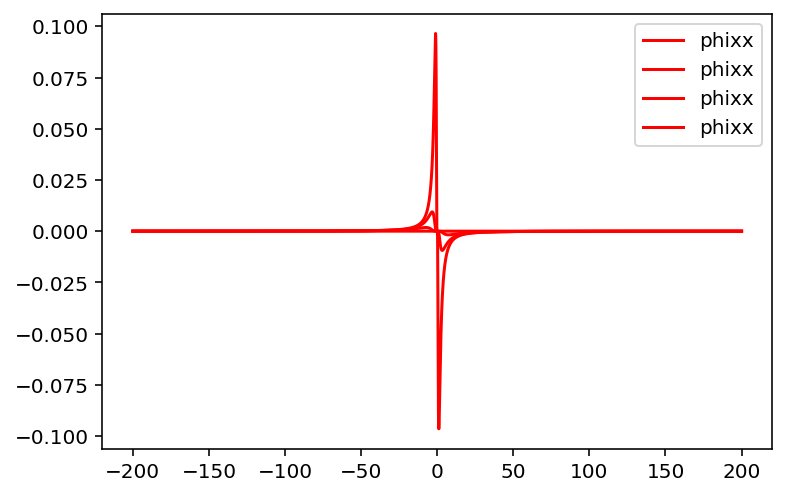

In [6]:
etal_pade_d = {}
expn_pade_d = {}

for npsd in [4, 9, 14, 512]:
    nmod = 4
    lams1 = 1
    lams2 = 1
    gams1 = 1
    gams2 = 1
    omgs1 = 0
    omgs2 = 0
    temp = 0.01
    npfs = 6
    beta = int(1 / temp)  # in 298K
    # eta = 1.0
    mu_x = 0

    w_sp, lams1_sp, gams1_sp, omgs1_sp, gams2_sp, lams2_sp, omgs2_sp, beta_sp = sp.symbols(
        r"\omega , \lambda_1, \gamma_1, \Omega_1, \lambda_2, \gamma_2, \Omega_2, \beta",
        real=True)

    phixx_sp = lams1_sp * gams1_sp**2 / ((w_sp - omgs1_sp)**2 + gams1_sp**2)
    phixy_sp = 0
    phiyy_sp = lams2_sp * gams2_sp**2 / ((w_sp - omgs2_sp)**2 + gams2_sp**2)


    sp_para_dict = {
        lams1_sp: lams1,
        lams2_sp: lams2,
        gams1_sp: gams1,
        gams2_sp: gams2,
        omgs1_sp: omgs1,
        omgs2_sp: omgs2
    }

    condition_dict = {}
    para_dict1 = {'beta': beta}
    para_dict2 = {'beta': beta}

    etal_pade1, etar_pade1, etaa_pade1, expn_pade1 = decompose_spe(
        phixx_sp, sp_para_dict, para_dict1, condition_dict, npsd, -1)
    etal_pade2, etar_pade2, etaa_pade2, expn_pade2 = decompose_spe(
        phiyy_sp, sp_para_dict, para_dict2, condition_dict, npsd, 1)
    npsd = npsd + 1

    n_spe = 1

    len_ = 10000
    spe_wid = 200
    w = np.linspace(-spe_wid, spe_wid, len_)
    res_w = np.zeros(len(w), dtype=complex)

    phixx = lams1 * gams1**2 / (((w - mu_x) - omgs1)**2 + gams1**2)
    phixy = 0 * w
    phiyy = lams2 * gams2**2 / (((w - mu_x) - omgs2)**2 + gams2**2)

    fit_J(w, res_w, expn_pade1, etal_pade1, 1)

    plt.plot(w, (phixx / (1 + np.exp(beta * (w - mu_x)))) -
             res_w.real,
             'r',
             label='phixx')

    plt.legend(loc='best')
    
    etal_pade_d[npsd] = etal_pade1
    expn_pade_d[npsd] = expn_pade1
# plt.savefig('spe.pdf')
# plt.clf()
expn_pade_d

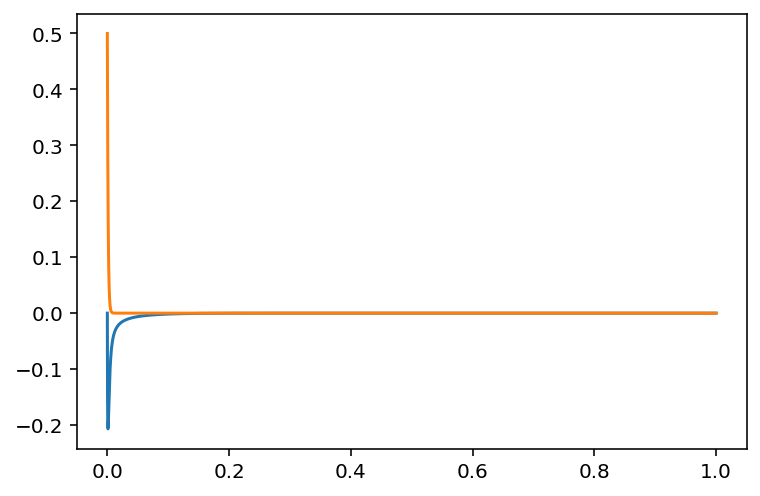

error of decompose 1.0277640915483067e-10
len of gamma 4


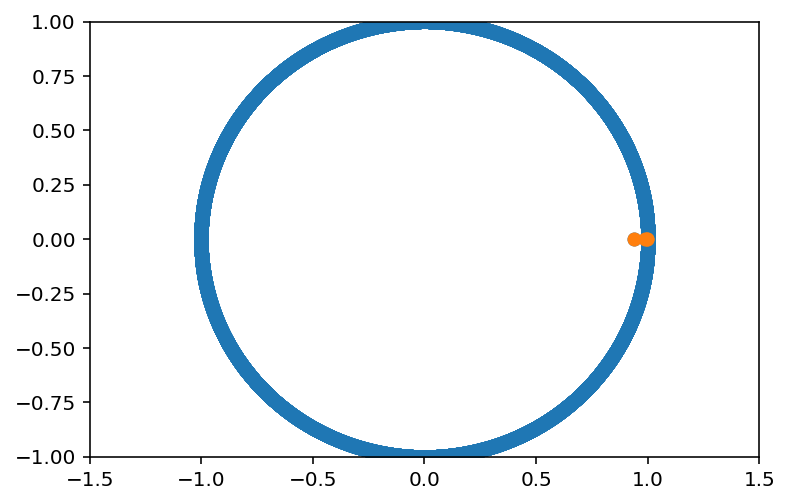

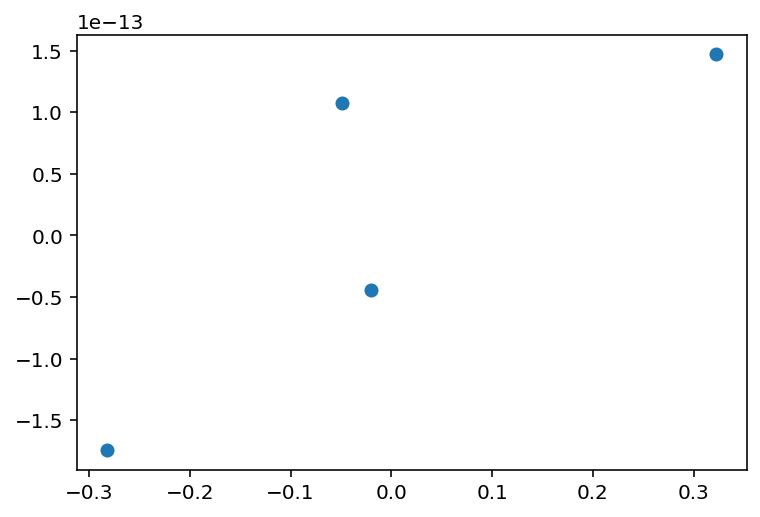

In [7]:
n = 15000
scale = 800
n_gamma = 4

n_sample = n + 1
t = np.linspace(0, 1, 2 * n + 1)
res_t = np.zeros(len(t), dtype=complex)
fit_t(scale * t, res_t, expn_pade1, etal_pade1)
plt.plot(t, np.imag(res_t))
plt.plot(t, np.real(res_t))
plt.show()
h = np.imag(res_t)
H = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H[i, :] = h[i:n_sample + i]
sing_vs, Q = LA.eigh(H)
phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
Qp = np.dot(Q, phase_mat)
sort_array = np.argsort(vs)[::-1]
vs = vs[sort_array]
Qp = (Qp[:, sort_array])
print(
    "error of decompose",
    np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))

print("len of gamma", n_gamma)
gamma = np.roots(Qp[:,n_gamma][::-1])
gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
t_new = 2*n*np.log(gamma_new)
plt.scatter(np.real(gamma),np.imag(gamma))
plt.scatter(np.real(gamma_new),np.imag(gamma_new))
plt.xlim(-1.5,1.5)
plt.ylim(-1,1)
plt.show()
gamma_m = np.zeros((n_sample*2-1, n_gamma), dtype=complex)
for i in range(n_gamma):
    for j in range(n_sample*2-1):
        gamma_m[j,i] = gamma_new[i]**j
omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)), np.dot(np.transpose(gamma_m), np.transpose(h)))
plt.scatter(np.real(omega_new),np.imag(omega_new))
plt.show()

In [8]:
# # plt.plot(t, np.imag(res_t))
# res_t1 = np.zeros(len(t), dtype=complex)
# fit_t(scale * t, res_t1, -t_new / scale, omega_new)
# plt.plot(t, np.imag(res_t) - res_t1)

In [9]:
etal1 = 1.j * omega_new
etar1 = np.conjugate(1.j * omega_new)
etaa1 = np.abs(omega_new)
expn1 = -t_new / scale
etal_real1, etar_real1, etaa_real1, expn_real1 = decompose_spe_real(
    phixx_sp, sp_para_dict, para_dict1, condition_dict, 1)

etal1 = np.append(etal1, etal_real1)
etar1 = np.append(etar1, etar_real1)
etaa1 = np.append(etaa1, etaa_real1)
expn1 = np.append(expn1, expn_real1)

# etal1 = np.append(etal1, etal_pade1[0])
# etar1 = np.append(etar1, etar_pade1[0])
# etaa1 = np.append(etaa1, etaa_pade1[0])
# expn1 = np.append(expn1, expn_pade1[0])

fermi_path = "../PFS/fermi-1-1/f-{}-comp/"
for npfs, beta in itertools.product([10], [100]):
    if os.path.exists((fermi_path + "etal1_{}").format(beta, npfs-1)):
        etal_prony1 = np.loadtxt((fermi_path + "etal1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn1_{}").format(beta, npfs-1)):
        expn_prony1 = np.loadtxt((fermi_path + "expn1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "etal2_{}").format(beta, npfs-1)):
        etal_prony2 = np.loadtxt((fermi_path + "etal2_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn2_{}").format(beta, npfs-1)):
        expn_prony2 = np.loadtxt((fermi_path + "expn2_{}").format(beta, npfs-1), dtype=complex)
        
# len_ = 10000
# spe_wid = 6

# w_origin = np.array([
#     -(np.linspace(0, spe_wid, len_))[::-1] - 0.5,
#     np.linspace(-0.5, 0.5, len_),
#     np.linspace(0, spe_wid, len_) + 0.5
# ]).flatten()
# w = np.array([
#     -10**(np.linspace(0, spe_wid, len_))[::-1],
#     np.linspace(-1, 1, len_), 10**np.linspace(0, spe_wid, len_)
# ]).flatten()

# w_sp, lamd_sp, gams_sp, beta_sp = sp.symbols(
#     r"\omega , \lambda, \gamma, \beta", real=True)

len_ = 100000
spe_wid = 20
w = np.linspace(-spe_wid, spe_wid, len_)
phixx = lams1 * gams1**2 / ((
    (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))
res_J1 = np.zeros(len(w), dtype=complex)
res_J1_10 = np.zeros(len(w), dtype=complex)
fit_J(w, res_J1, expn1, etal1, 1)
fit_J(w, res_J1_10, expn_prony1, etal_prony1, 1)
res_J1_pade_d = {}
for npsd in [5, 10, 15]:
    etal_pade1 = etal_pade_d[npsd]
    expn_pade1 = expn_pade_d[npsd]
    res_J1_pade = np.zeros(len(w), dtype=complex)
    fit_J(w, res_J1_pade, expn_pade1, etal_pade1, 1)
    res_J1_pade_d[npsd] = res_J1_pade

[-1.0*I, 1.0*I]


/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp


In [10]:
# from matplotlib import rc
# from matplotlib import rcParams
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
# rc('text', usetex=True)
# plt.rc('font', family='serif')
# params = {
#     'text.latex.preamble': [
#         r'\usepackage{amsmath}\usepackage[dvips]{graphicx}\usepackage{xfrac}\usepackage{scalerel}\usepackage{siunitx}\usepackage{bm}'
#     ]
# }
# rcParams['axes.linewidth'] = 2
# rcParams['lines.linewidth'] = 1.5
# rcParams['xtick.major.width'] = 3
# rcParams['xtick.minor.size'] = 5
# rcParams['ytick.minor.size'] = 5
# rcParams['xtick.major.size'] = 7
# rcParams['ytick.major.size'] = 7
# rcParams['xtick.minor.width'] = 1.5
# rcParams['xtick.major.width'] = 1.5
# rcParams['ytick.minor.width'] = 1.5
# rcParams['ytick.major.width'] = 1.5
# plt.rcParams.update(params)
# plt.rcParams['figure.figsize'] = [5, 4]
# fontsize = 10
# sca_size = 2
# plt.rc('font', size=fontsize)  #controls default text size
# plt.rc('axes', titlesize=fontsize)  #fontsize of the title
# plt.rc('axes', labelsize=fontsize)  #fontsize of the x and y labels
# plt.rc('xtick', labelsize=fontsize)  #fontsize of the x tick labels
# plt.rc('ytick', labelsize=fontsize)  #fontsize of the y tick labels
# plt.rc('legend', fontsize=fontsize)  #fontsize of the legend
# f, axes = plt.subplots(1, 1, sharey=False, sharex=False)

# axes.set_position([0.1, 0.1, 0.85, 0.85])
# axes.xaxis.set_tick_params(direction='in', which='both', bottom=True, top=True)
# axes.yaxis.set_tick_params(direction='in', which='both', left=True, right=True)

# axes.plot(w_origin, np.log10(phixx), 'r', label = r'$C(\omega)$')
# # axes.plot(w_origin, w, 'r')
# axes.plot(w_origin, np.log10(res_J1.real), 'g-.', label = r'PFS: 10')
# c_d = {10: 'b--', 20: 'k--', 30: 'm--'}
# l_d = {10: r'PSD: 10', 20: r'PSD: 20', 30: r'PSD: 30'}
# for npsd in [10, 20, 30]:
#     res_J1_pade = res_J1_pade_d[npsd]
#     axes.plot(w_origin, np.log10(res_J1_pade.real), c_d[npsd], label = l_d[npsd])
# axes.set_xticks([-6.5, -4.5, -2.5, -0.5, 0.5, 2.5, 4.5, 6.5])
# axes.set_xticklabels([
#     r'$-10^6$', r'$-10^{4}$', r'$-10^{2}$', -1, 1, r'$10^2$', r'$10^4$',
#     r'$10^6$'
# ])
# minor_xticks = np.array([-0.25, 0, 0.25])

# for i in range(0, spe_wid, 2):
#     minor_xticks = np.append(minor_xticks,
#                              -np.log10([20, 40, 60, 80]) - 4.5 + i)
# for i in range(0, spe_wid, 2):
#     minor_xticks = np.append(minor_xticks,
#                              np.log10([20, 40, 60, 80]) + 0.5 + i)

# axes.set_xticks(minor_xticks, minor=True)

# axes.set_yticks([-10, -8, -6, -4, -2, 0])
# axes.set_yticklabels([
#     r'$10^{-10}$', r'$10^{-8}$', r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$',
#     r'$10^{0}$'
# ])

# axes.set_ylim(-10.5, 0.5)
# axes.set_xlim(-6.75, 6.75)
# # plt.ylim(-100.5, 0.5)
# axes.legend(loc='best').get_frame().set_linewidth(0.0)
# plt.savefig('fig1.eps', format='eps')

In [11]:
phixx_real_semi = np.loadtxt("phixx.real")
res_J1_real_semi = np.loadtxt("res_J1.real")
w_real_semi = np.loadtxt("w.real")

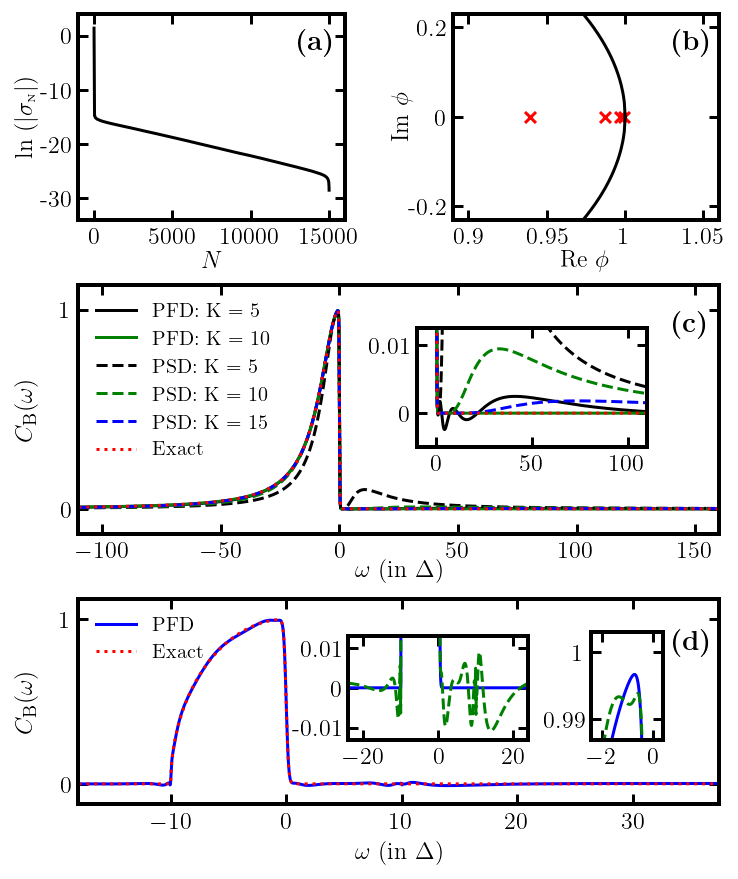

In [12]:
from matplotlib import rc
from matplotlib import rcParams
import dill

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')
# params = {
#     'text.latex.preamble': [
#         r'\usepackage{amsmath}\usepackage[dvips]{graphicx}\usepackage{xfrac}\usepackage{scalerel}\usepackage{siunitx}\usepackage{bm}'
#     ]
# }
rcParams['axes.linewidth'] = 2
rcParams['lines.linewidth'] = 1.5
rcParams['xtick.major.width'] = 3
rcParams['xtick.minor.size'] = 5
rcParams['xtick.major.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['ytick.major.size'] = 5
rcParams['xtick.minor.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.minor.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
params = {}
plt.rcParams.update(params)
plt.rcParams['figure.figsize'] = [5, 6]
fontsize = 12
sca_size = 2
plt.rc('font', size=fontsize)  #controls default text size
plt.rc('axes', titlesize=fontsize)  #fontsize of the title
plt.rc('axes', labelsize=fontsize)  #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)  #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize)  #fontsize of the y tick labels
plt.rc('legend', fontsize=10)  #fontsize of the legend

f, axes = plt.subplots(3, 2, sharey=False, sharex=False)

begin_y = 0.075
end_y = 0.99
int_y = 0.1
begin_x = 0.1
end_x = 0.99
int_x = 0.15
end_x += int_x
end_y += int_y

shapexy = np.shape(axes)
inter_x = np.linspace(begin_x, end_x, shapexy[1] + 1)
inter_y = np.linspace(begin_y, end_y, shapexy[0] + 1)

delta_x = inter_x[1] - inter_x[0] - int_x
delta_y = inter_y[1] - inter_y[0] - int_y

text_l = [[r'\textbf{(c)}', r'\textbf{(d)}'],
          [r'\textbf{(a)}', r'\textbf{(b)}']]
for i in range(shapexy[0]):
    for j in range(shapexy[1]):
        axes[i][j].set_position([
            inter_x[j], inter_y[i], inter_x[j + 1] - inter_x[j] - int_x,
            inter_y[i + 1] - inter_y[i] - int_y
        ])
        axes[i][j].xaxis.set_tick_params(direction='in',
                                         which='both',
                                         bottom=True,
                                         top=True)
        axes[i][j].yaxis.set_tick_params(direction='in',
                                         which='both',
                                         left=True,
                                         right=True)
fontsize += 2
axes[1][0].text(0.825,
                0.875,
                text_l[0][0],
                fontsize=fontsize,
                transform=axes[1][1].transAxes)
axes[2][0].text(0.825,
                0.825,
                text_l[1][0],
                fontsize=fontsize,
                transform=axes[2][0].transAxes)
axes[2][1].text(0.825,
                0.825,
                text_l[1][1],
                fontsize=fontsize,
                transform=axes[2][1].transAxes)
axes[0][0].text(0.825,
                0.75,
                r'\textbf{(d)}',
                fontsize=fontsize,
                transform=axes[0][1].transAxes)

axes[1][0].set_position([
    inter_x[0], inter_y[1] - 0.025, inter_x[2] - inter_x[0] - int_x,
    inter_y[2] - inter_y[1] - 0.05
])

axes[1][0].plot(10 * w, ((res_J1.real)), 'k', label='PFD: K = 5')
axes[1][0].plot(10 * w, ((res_J1_10.real)), 'g', label='PFD: K = 10')
axes[1][0].plot(10 * w, ((res_J1_pade_d[5].real)), 'k--', label=r'PSD: K = 5')
axes[1][0].plot(10 * w, ((res_J1_pade_d[10].real)), 'g--', label=r'PSD: K = 10')
axes[1][0].plot(10 * w, ((res_J1_pade_d[15].real)), 'b--', label=r'PSD: K = 15')
axes[1][0].plot(10 * w, ((phixx.real)), 'r:', label=r'Exact')

axes[1][0].set_xlim(-110, 160)
axes[1][0].legend(loc="upper left",
                  framealpha=0.0).get_frame().set_linewidth(0.0)
axes[1][0].set_ylim(-0.125, 1.125)
axes[1][0].set_yticks([0, 1])
axes[1][0].set_yticklabels(['$0$', '$1$'])
axes[1][0].set_xlabel(r'$\omega$ (in $\Delta$)')
axes[1][0].set_ylabel(r'$C_{\mbox{\small B}}(\omega)$')
axes[1][0].yaxis.set_label_coords(-0.0625, 0.5)
axes[1][0].xaxis.set_label_coords(0.5, -0.1)

axes_p = f.add_subplot(1,1,1)
axes_p.set_position([
    inter_x[1] - 0.1 + 0.05, inter_y[1] + 0.075,
    inter_x[2] - inter_x[1] - int_x - 0.05,
    inter_y[2] - inter_y[1] - int_y - 0.1
])
axes_p.xaxis.set_tick_params(direction='in',
                                 which='both',
                                 bottom=True,
                                 top=True)
axes_p.yaxis.set_tick_params(direction='in',
                                 which='both',
                                 left=True,
                                 right=True)
axes_p.plot(10 * w, (res_J1.real), 'k')
axes_p.plot(10 * w, (res_J1_10.real), 'g')
axes_p.plot(10 * w, (res_J1_pade_d[5].real), 'k--')
axes_p.plot(10 * w, (res_J1_pade_d[10].real), 'g--')
axes_p.plot(10 * w, (res_J1_pade_d[15].real), 'b--')
axes_p.plot(10 * w, np.abs(phixx.real), 'r:')
axes_p.set_xlim(-10, 110)
axes_p.set_ylim(-0.005, 0.0125)
axes_p.set_yticks([0, 0.01])
axes_p.set_yticklabels(['$0$', '$0.01$'])

# 
x = np.linspace(0.5, 1, 1000)
y = np.sqrt(1 - x * x)
axes[2][1].plot(x, y, 'k')
axes[2][1].plot(x, -y, 'k')
axes[2][1].scatter(np.real(gamma_new),
                   np.imag(gamma_new),
                   marker='x',
                   color='r',
                   s=15 * sca_size)
axes[2][1].set_xlim(0.89, 1.06)
axes[2][1].set_ylim(-0.23, 0.23)
axes[2][1].set_yticks([-0.2, 0, 0.2])
axes[2][1].set_yticklabels([-0.2, 0, 0.2])
axes[2][1].set_xticks([0.9, 0.95, 1, 1.05])
axes[2][1].set_xticklabels([0.9, 0.95, 1, 1.05])

axes[2][0].plot(np.log10(vs), 'k')
axes[2][0].set_xlabel(r'$N$')
axes[2][0].set_ylabel(r'ln $(|\sigma_{\mbox{\tiny N}}|)$')
axes[2][0].set_ylim(-34, 4)
axes[2][0].set_xlim(-1000, 16000)
axes[2][0].set_yticks([0, -10, -20, -30])
axes[2][0].set_yticklabels(
    [r'$0$', r'-$10$', r'-$20$', r'-$30$'])
axes[2][0].set_xticks([0, 5000, 10000, 15000])
axes[2][0].set_xticklabels([0, 5000, 10000, 15000])
axes[2][1].set_xlabel('Re $\phi$')
axes[2][1].set_ylabel('Im $\phi$')

axes[2][1].yaxis.set_label_coords(-0.15, 0.5)
axes[2][0].yaxis.set_label_coords(-0.15, 0.5)

axes[2][1].xaxis.set_label_coords(0.5, -0.15)
axes[2][0].xaxis.set_label_coords(0.5, -0.15)

axes[0][0].set_position([
    inter_x[0], inter_y[0], inter_x[2] - inter_x[0] - int_x,
    inter_y[1] - inter_y[0] - int_y
])
axes[0][0].set_xlim(-18, 37.5)
axes[0][0].set_ylim(-0.125, 1.125)
axes[0][0].set_yticks([0, 1])
axes[0][0].set_ylabel(r'$C_{\mbox{\small B}}(\omega)$')
axes[0][0].yaxis.set_label_coords(-0.0625, 0.5)
axes[1][0].xaxis.set_label_coords(0.5, -0.1)
axes[0][0].set_xlabel(r'$\omega$ (in $\Delta$)')

axes[0][0].plot(10 * w_real_semi, res_J1_real_semi, "b", label="PFD")
axes[0][0].plot(10 * w_real_semi, phixx_real_semi, "r:", label="Exact")
axes[0][0].legend(loc="upper left", framealpha=0.0).get_frame().set_linewidth(0.0)

axes_p1 = f.add_subplot(2,1,1)
axes_p1.xaxis.set_tick_params(direction='in',
                                 which='both',
                                 bottom=True,
                                 top=True)
axes_p1.yaxis.set_tick_params(direction='in',
                                 which='both',
                                 left=True,
                                 right=True)
axes_p1.set_position([0.475, 0.15, 0.25, 0.12])
axes_p1.set_xlim(-24, 24)
axes_p1.set_ylim(-0.013, 0.013)
axes_p1.set_yticks([-0.01, 0, 0.01])
axes_p1.set_yticklabels(['-0.01', '0', '0.01'])
axes_p1.plot(10*w_real_semi, phixx_real_semi, "b")
axes_p1.plot(10*w_real_semi, res_J1_real_semi, "g--")


axes_p2 = f.add_subplot(1,2,1)
axes_p2.xaxis.set_tick_params(direction='in',
                                 which='both',
                                 bottom=True,
                                 top=True)
axes_p2.yaxis.set_tick_params(direction='in',
                                 which='both',
                                 left=True,
                                 right=True)
axes_p2.set_position([0.8125, 0.15, 0.1, 0.125])
axes_p2.set_xlim(-2.4, 0.4)
axes_p2.set_ylim(0.987, 1.003)
axes_p2.set_yticks([0.99, 1])
axes_p2.set_yticklabels(['0.99', '1'])
axes_p2.plot(10*w_real_semi, phixx_real_semi, "b")
axes_p2.plot(10*w_real_semi, res_J1_real_semi, "g--")

f.delaxes(axes[1][1])
f.delaxes(axes[0][1])

plt.savefig("fig1.eps", format='eps')
plt.savefig("fig1.pdf")

In [42]:
import pickle
with open("vs", 'wb') as f:
    pickle.dump(vs, f)

In [45]:
nmod = 4
lams1 = 1
lams2 = 1
gams1 = 1
gams2 = 1
omgs1 = 0
omgs2 = 0
mu_x = 0
etal_pade_d = {}
expn_pade_d = {}
res_J1_pade_d = {}
pade_l = {100: [15], 1000: [45], 10000: [120]}
beta_l = [100, 1000, 10000]
prony_l = {100:4, 1000:6, 10000:8}
etal_prony1 = {}
expn_prony1 = {}
etal_prony2 = {}
expn_prony2 = {}

for beta in beta_l:
    etal_pade_d[beta] = {}
    expn_pade_d[beta] = {}
    res_J1_pade_d[beta] = {}

for beta in beta_l:
    for npsd in pade_l[beta]:
        npsd -= 1
        w_sp, lams1_sp, gams1_sp, omgs1_sp, gams2_sp, lams2_sp, omgs2_sp, beta_sp = sp.symbols(
            r"\omega , \lambda_1, \gamma_1, \Omega_1, \lambda_2, \gamma_2, \Omega_2, \beta",
            real=True)
        phixx_sp = lams1_sp * gams1_sp**2 / ((w_sp - omgs1_sp)**2 + gams1_sp**2)
        phiyy_sp = lams2_sp * gams2_sp**2 / ((w_sp - omgs2_sp)**2 + gams2_sp**2)
        sp_para_dict = {
            lams1_sp: lams1,
            lams2_sp: lams2,
            gams1_sp: gams1,
            gams2_sp: gams2,
            omgs1_sp: omgs1,
            omgs2_sp: omgs2
        }
        condition_dict = {}
        para_dict1 = {'beta': beta}
        para_dict2 = {'beta': beta}
        etal_pade1, etar_pade1, etaa_pade1, expn_pade1 = decompose_spe(
            phixx_sp, sp_para_dict, para_dict1, condition_dict, npsd, -1)
        etal_pade2, etar_pade2, etaa_pade2, expn_pade2 = decompose_spe(
            phiyy_sp, sp_para_dict, para_dict2, condition_dict, npsd, 1)
        npsd = npsd + 1
        etal_pade_d[beta][npsd] = etal_pade1
        expn_pade_d[beta][npsd] = expn_pade1

fermi_path = "../PFS/fermi-1-1/f-{}-comp/"
for beta in beta_l:
    npfs = prony_l[beta]
    if os.path.exists((fermi_path + "etal1_{}").format(beta, npfs-1)):
        etal_prony1[beta] = np.loadtxt((fermi_path + "etal1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn1_{}").format(beta, npfs-1)):
        expn_prony1[beta] = np.loadtxt((fermi_path + "expn1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "etal2_{}").format(beta, npfs-1)):
        etal_prony2[beta] = np.loadtxt((fermi_path + "etal2_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn2_{}").format(beta, npfs-1)):
        expn_prony2[beta] = np.loadtxt((fermi_path + "expn2_{}").format(beta, npfs-1), dtype=complex)

len_ = 1000000
spe_wid = 0.04
w = np.linspace(-spe_wid, spe_wid, len_)
for beta in beta_l:
    phixx = lams1 * gams1**2 / ((
        (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))
    res_J1_prony = np.zeros(len(w), dtype=complex)
    fit_J(w, res_J1_prony, expn_prony1[beta], etal_prony1[beta], 1)
    res_J1_pade_d[beta]['exact'] = phixx.real
    res_J1_pade_d[beta]['prony'] = res_J1_prony.real

for beta in beta_l:
    for npsd in pade_l[beta]:
        etal_pade1 = etal_pade_d[beta][npsd]
        expn_pade1 = expn_pade_d[beta][npsd]
        res_J1_pade = np.zeros(len(w), dtype=complex)
        fit_J(w, res_J1_pade, expn_pade1, etal_pade1, 1)
        res_J1_pade_d[beta][npsd] = res_J1_pade.real

[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122326e+03 1.93455891e+03 2.53583053e+03
 3.34335371e+03 4.79579604e+03 8.00364386e+03 1.72570040e+04
 6.73472767e+04]
3.1415926535897936
9.424777960769369
15.70796326794898
21.991148575128555
28.274333882312707
34.5575192533683
40.84078430205396
47.137662457594864
53.811247757121464
62.80764445294167
77.79554015928062
106.09197367207202
173.89298668582776
517.4557854549213
[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122326e+03 1.93455891e+03 2.53583053e+03
 3.34335371e+03 4.79579604e+03 8.00364386e+03 1.72570040e+04
 6.73472767e+04]
3.1415926535897936
9.424777960769369
15.70796326794898
21.991148575128555
28.274333882312707
34.5575192533683
40.84078430205396
47.137662457594864
53.811247757121464
62.80764445294167
77.79554015928062
106.09197367207202
173.89298668582776
517.4557854549213
[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.553

/home/dhem/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


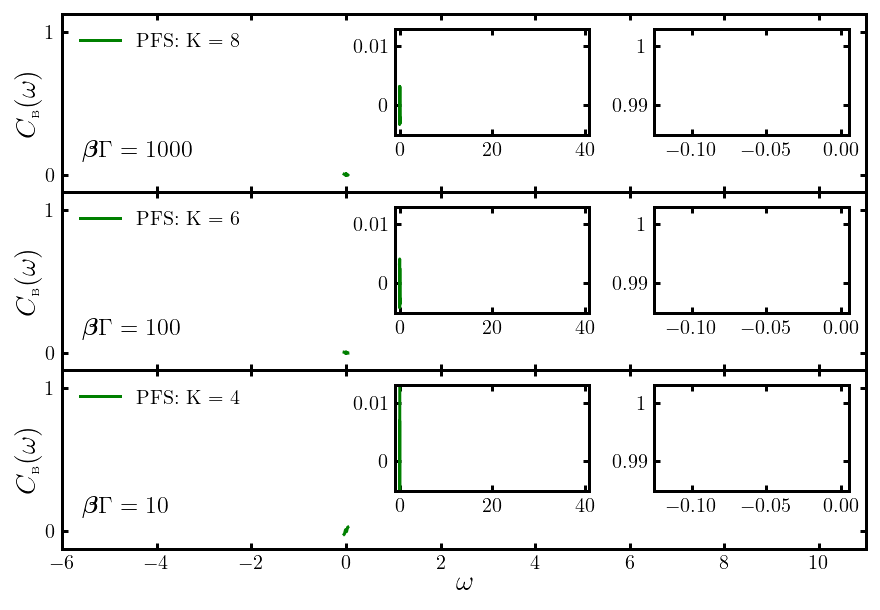

In [46]:
from matplotlib import rc
from matplotlib import rcParams
import dill

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')
params = {
    'text.latex.preamble': [
        r'\usepackage{amsmath}\usepackage[dvips]{graphicx}\usepackage{xfrac}\usepackage{scalerel}\usepackage{siunitx}\usepackage{bm}'
    ]
}
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 1.5
rcParams['xtick.major.width'] = 3
rcParams['xtick.minor.size'] = 2
rcParams['ytick.minor.size'] = 2
rcParams['xtick.major.size'] = 3
rcParams['ytick.major.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.minor.width'] = 1
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['figure.figsize'] = [6, 4]

plt.rcParams.update(params)
fontsize = 10
sca_size = 2
plt.rc('font', size=fontsize)  #controls default text size
plt.rc('axes', labelsize=fontsize + 4)  #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)  #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize)  #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize)  #fontsize of the legend
f, axes = plt.subplots(3, len(beta_l), sharey=False, sharex=False)

begin_y = 0.0675
end_y = 0.995
begin_x = 0.06
end_x = 0.99
shapexy = np.shape(axes)
inter_x = np.linspace(begin_x, end_x, shapexy[0] + 1)
inter_y = np.linspace(begin_y, end_y, shapexy[1] + 1)
delta_x = end_x - begin_x
delta_y = inter_y[1] - inter_y[0]

for i in range(shapexy[0]):
    for j in range(shapexy[1]):
        axes[i][j].xaxis.set_tick_params(direction='in',
                                         which='both',
                                         bottom=True,
                                         top=True)
        axes[i][j].yaxis.set_tick_params(direction='in',
                                         which='both',
                                         left=True,
                                         right=True)

move_sub_x = 0.075
int_sub_x = 0.075
delta_sub_x = 0.225

for i in range(shapexy[1]):
    axes[0][i].set_position([inter_x[0], inter_y[i], delta_x, delta_y])
    axes[0][i].set_xlim(-6, 11)
    axes[0][i].set_ylim(-0.125, 1.125)
    axes[0][i].set_yticks([0, 1])
    axes[0][i].set_ylabel(r'$C_{\mbox{\tiny B}}(\omega)$')
    axes[0][i].yaxis.set_label_coords(-0.025, 0.5)
    axes[1][i].set_position(
        [inter_x[1] + move_sub_x, inter_y[i] + 0.1, delta_sub_x, delta_y - 0.125])
    axes[1][i].set_xlim(-1, 41)
    axes[1][i].set_ylim(-0.005, 0.013)
    axes[1][i].set_yticks([0, 0.01])
    axes[1][i].set_yticklabels(['0', '0.01'])
    axes[2][i].set_position([
        inter_x[1] + move_sub_x + delta_sub_x + int_sub_x, inter_y[i] + 0.1, delta_sub_x,
        delta_y - 0.125
    ])
    axes[2][i].set_xlim(-0.125, 0.005)
    axes[2][i].set_ylim(0.985, 1.003)
    axes[2][i].set_yticks([0.99, 1])
    axes[2][i].set_yticklabels(['0.99', '1'])

for i in range(1):
    axes[i][0].xaxis.set_label_coords(0.5, -0.125)
    axes[i][0].set_xlabel(r'$\omega$')
    axes[i][1].set_xticklabels([])
    axes[i][2].set_xticklabels([])

c_l = ['k--', 'g--', 'b--']

for x_i in range(len(beta_l)):
    for y_i in range(shapexy[0]):
        axes[y_i][x_i].plot(w,
                            res_J1_pade_d[beta_l[x_i]]['exact'] - res_J1_pade_d[beta_l[x_i]]['prony'],
                            'g',
                            label='PFS: K = {}'.format(prony_l[beta_l[x_i]]))
#         for i in range(len(pade_l[beta_l[x_i]])):
#             axes[y_i][x_i].plot(
#                 w, (res_J1_pade_d[beta_l[x_i]][pade_l[beta_l[x_i]][i]].real),
#                 c_l[i],
#                 label=r'PSD: K = {}'.format(pade_l[beta_l[x_i]][i]))
#         axes[y_i][x_i].plot(w,
#                             res_J1_pade_d[beta_l[x_i]]['exact'],
#                             'r:',
#                             label=r'Exact')
    axes[0][x_i].legend(loc="upper left",
                        framealpha=0.0).get_frame().set_linewidth(0.0)

str_label_l = [r"$\bm \beta \Gamma = 1000$", r"$\bm \beta \Gamma = 100$", r"$\bm \beta \Gamma = 10$"]
str_label_index = shapexy[1] - 1
for x_i in range(shapexy[1]):
    axes[0][x_i].text(0.025,
                      0.2,
                      str_label_l[str_label_index],
                      ha='left',
                      fontsize=12,
                      transform=axes[0][x_i].transAxes)
    str_label_index -= 1
# plt.savefig("fig1.eps", format='eps')
# plt.savefig("fig1.pdf")
plt.savefig("fig4.png", dpi=300)

/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(0.0, 0.1)

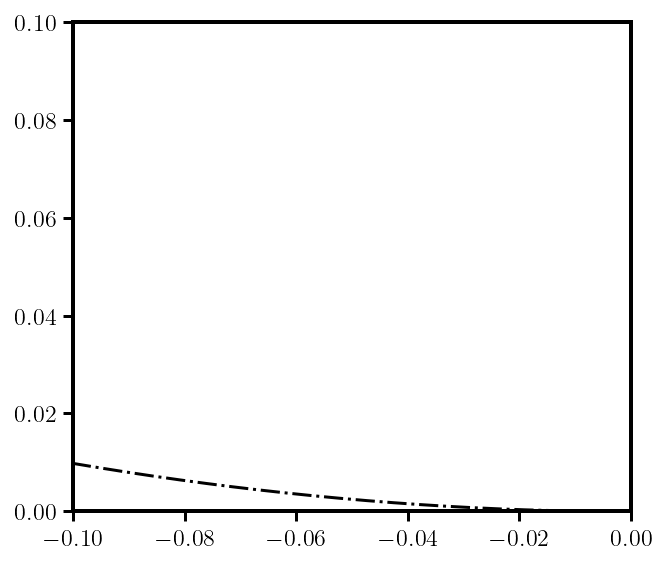

In [64]:
phixx = 10**2 / (((w - mu_x) - omgs1)**2 + 10**2) / (1 + np.exp(beta *
                                                                (w - mu_x)))
plt.plot(w, np.abs(phixx.real), 'r')
phixx = 1 * gams1**2 / ((
    (w - mu_x) - omgs1)**2 + 1**2) / (1 + np.exp(beta * (w - mu_x)))
plt.plot(w, np.abs(phixx.real), 'b:')

phixx = 10**2 / (((w - mu_x) - omgs1)**2 +
                 10**2) / (1 + np.exp(beta * (w - mu_x))) - 1 * gams1**2 / ((
                     (w - mu_x) - omgs1)**2 + 1**2) / (1 + np.exp(beta *
                                                                  (w - mu_x)))
plt.plot(w, np.abs(phixx.real), 'k-.')

plt.xlim(-0.1, 0)
plt.ylim(0, 0.1)

In [28]:
# import dill                            #pip install dill --user
# filename = 'globalsave.pkl'
# dill.dump_session(filename)

# # and to load the session again:
# dill.load_session(filename)

In [47]:
0.00001 * 100000

1.0